In [1]:
from strategy.speculation import Speculation
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
import numpy as np
import matplotlib.pyplot as plt

In [2]:
start_date = datetime(2016,1,1)
end_date = datetime(2021,1,1)
spec = Speculation(start_date,end_date)

In [3]:
spec.subscribe()
# spec.initial_transform()
# sim = spec.create_sim()

In [4]:
transforms = spec.rec_transform()

In [ ]:
models = spec.model()

In [ ]:
recs = spec.recommend()

In [33]:
start_year = spec.start_date.year
end_year = spec.end_date.year
spec.db.connect()
data = spec.db.retrieve("transformed")
spec.db.disconnect()
stock_category = spec.subscriptions["stock_category"]["db"]
stock_category.connect()
categories = stock_category.retrieve("sim")
stock_category.disconnect()
number_of_training_weeks = spec.modeling_params["number_of_training_weeks"]
model_training_year = spec.modeling_params["model_training_year"]
categories_nums = spec.modeling_params["categories"]
sims = []
market = spec.subscriptions["market"]["db"]
market.connect()
spec.db.connect()
for year in tqdm(range(2017,2018),desc="speculation_sim_year"):
    for quarter in range(1,5):
        quarterly_categories = categories[(categories["year"]==year) & (categories["quarter"]==quarter)]
        for category in list(quarterly_categories[f"{categories_nums}_classification"].unique()[2:3]):
            try:
                category_tickers = quarterly_categories[quarterly_categories[f"{categories_nums}_classification"]==category]["ticker"].unique()
                model_data = data[(data["ticker"].isin(category_tickers))]
                model_data.sort_values("date",ascending=True,inplace=True)
                model_data.reset_index(inplace=True)
                first_index = model_data[(model_data["year"] == (year - model_training_year - 1)) & (model_data["quarter"]==quarter)].index.values.tolist()[0]
                last_index = model_data[(model_data["year"] == year) & (model_data["quarter"]==quarter)].index.values.tolist()[0]
                training_data = model_data.iloc[first_index:last_index].reset_index()
                prediction_data = model_data[(model_data["year"] == year) & (model_data["quarter"]==quarter)].reset_index()
                print(year,quarter,category,len(category_tickers),training_data.index.size,prediction_data.index.size)
                X = training_data[[str(x) for x in range(number_of_training_weeks)]]
                y = training_data["y"]
                models = m.regression({"X":X,"y":y})
                models["year"] = year
                models["quarter"] = quarter
                models["category"] = category
                sim = prediction_data
                for i in range(models.index.size):
                    model = models.iloc[i]
                    api = model["api"]
                    score = model["score"]
                    if score >= spec.modeling_params["score_requirement"]/100:
                        sim[f"{api}_prediction"] = model["model"].predict(sim[[str(x) for x in range(number_of_training_weeks)]])
                        sim[f"{api}_score"] = model["score"].item()
                stuff = []
                for ticker in category_tickers:
                    ticker_data = market.retrieve_ticker_prices("prices",ticker)
                    stuff.append(ticker_data)
                prices = p.column_date_processing(pd.concat(stuff))
                prices["year"] = [x.year for x in prices["date"]]
                prices["week"] = [x.week for x in prices["date"]]
                sim = p.column_date_processing(sim)
                sim["year"] = [x.year for x in sim["date"]]
                sim["week"] = [x.week for x in sim["date"]]
                sim = prices[["date","year","week","ticker","adjclose"]].merge(sim.drop(["date","adjclose"],axis=1),on=["year","week","ticker"],how="right").dropna()
                sim["categories"] = categories_nums
                final_cols = ["date","ticker","adjclose","categories"]
                final_cols.extend([x for x in list(sim.columns) if "prediction" in x or "score" in x])
                sim = sim[final_cols]
                sim.fillna(0,inplace=True)
                sim["prediction"] = [np.nanmean([row[1][x] for x in sim.columns if "prediction" in x and row[1][x] != 0]) for row in sim.iterrows()]
                sim["score"] = [np.nanmean([row[1][x] for x in sim.columns if "score" in x and row[1][x] != 0]) for row in sim.iterrows()]
                sim["delta"] = (sim["prediction"] - sim["adjclose"]) / sim["adjclose"]
                for param in spec.modeling_params:
                    sim[param]=spec.modeling_params[param]
                if sim.index.size > 1:
                    spec.db.store("sim",sim)
                    sims.append(sim)
            except Exception as e:
                print(category,str(e))
spec.db.disconnect()
market.disconnect()

speculation_sim_year:   0%|                                                                                                           | 0/1 [00:00<?, ?it/s]

2017 1 Information Technology 73 7803 936
2017 2 Information Technology 73 7843 945
2017 3 Information Technology 73 7809 949
2017 4 Information Technology 73 7777 949


speculation_sim_year: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [04:31<00:00, 271.72s/it]


In [44]:
sim

,date,ticker,adjclose,categories,skl_prediction,skl_score,xgb_prediction,xgb_score,light_prediction,light_score,cat_prediction,cat_score,prediction,score,delta,number_of_training_weeks,model_training_year,score_requirement
0,2017-10-02,CTXS,76.602913,2,77.257407,0.997542,76.812050,0.996796,68.919176,0.951552,76.101315,0.996276,74.772487,0.985542,-0.023895,14,1,70
1,2017-10-03,CTXS,75.648990,2,77.257407,0.997542,76.812050,0.996796,68.919176,0.951552,76.101315,0.996276,74.772487,0.985542,-0.011586,14,1,70
2,2017-10-04,CTXS,75.446643,2,77.257407,0.997542,76.812050,0.996796,68.919176,0.951552,76.101315,0.996276,74.772487,0.985542,-0.008936,14,1,70
3,2017-10-05,CTXS,76.776354,2,77.257407,0.997542,76.812050,0.996796,68.919176,0.951552,76.101315,0.996276,74.772487,0.985542,-0.026100,14,1,70
4,2017-10-06,CTXS,76.574007,2,77.257407,0.997542,76.812050,0.996796,68.919176,0.951552,76.101315,0.996276,74.772487,0.985542,-0.023527,14,1,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,2017-12-29,MPWR,108.649195,2,108.440358,0.997542,111.407837,0.996796,98.295821,0.951552,110.273826,0.996276,107.104460,0.985542,-0.014218,14,1,70
4595,2017-12-26,MXIM,48.282936,2,48.051127,0.997542,48.968910,0.996796,43.678333,0.951552,47.862732,0.996276,47.140275,0.985542,-0.023666,14,1,70
4596,2017-12-27,MXIM,48.044728,2,48.051127,0.997542,48.968910,0.996796,43.678333,0.951552,47.862732,0.996276,47.140275,0.985542,-0.018825,14,1,70
4597,2017-12-28,MXIM,48.402040,2,48.051127,0.997542,48.968910,0.996796,43.678333,0.951552,47.862732,0.996276,47.140275,0.985542,-0.026068,14,1,70


In [34]:
models

,api,model,score,model_type,year,quarter,category
0,skl,LinearRegression(),0.997542,regression,2017,4,Information Technology
1,xgb,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.996796,regression,2017,4,Information Technology
2,light,"LGBMRegressor(boosting_type='dart', early_stop...",0.951552,regression,2017,4,Information Technology
3,cat,<catboost.core.CatBoostRegressor object at 0x0...,0.996276,regression,2017,4,Information Technology


In [54]:
analysis = pd.concat(sims)

In [55]:
analysis

,date,ticker,adjclose,categories,skl_prediction,skl_score,xgb_prediction,xgb_score,light_prediction,light_score,cat_prediction,cat_score,prediction,score,delta,number_of_training_weeks,model_training_year,score_requirement
0,2017-01-03,NXPI,93.934850,2,94.595498,0.996817,93.882683,0.996155,84.671511,0.951068,93.487962,0.995987,91.659413,0.985007,-0.024224,14,1,70
1,2017-01-04,NXPI,94.550438,2,94.595498,0.996817,93.882683,0.996155,84.671511,0.951068,93.487962,0.995987,91.659413,0.985007,-0.030577,14,1,70
2,2017-01-05,NXPI,94.646623,2,94.595498,0.996817,93.882683,0.996155,84.671511,0.951068,93.487962,0.995987,91.659413,0.985007,-0.031562,14,1,70
3,2017-01-06,NXPI,94.463871,2,94.595498,0.996817,93.882683,0.996155,84.671511,0.951068,93.487962,0.995987,91.659413,0.985007,-0.029688,14,1,70
4,2017-01-03,FTNT,30.120000,2,30.819389,0.996817,31.313322,0.996155,27.547421,0.951068,30.569720,0.995987,30.062463,0.985007,-0.001910,14,1,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,2017-12-29,MPWR,108.649195,2,108.440358,0.997542,111.407837,0.996796,98.295821,0.951552,110.273826,0.996276,107.104460,0.985542,-0.014218,14,1,70
4595,2017-12-26,MXIM,48.282936,2,48.051127,0.997542,48.968910,0.996796,43.678333,0.951552,47.862732,0.996276,47.140275,0.985542,-0.023666,14,1,70
4596,2017-12-27,MXIM,48.044728,2,48.051127,0.997542,48.968910,0.996796,43.678333,0.951552,47.862732,0.996276,47.140275,0.985542,-0.018825,14,1,70
4597,2017-12-28,MXIM,48.402040,2,48.051127,0.997542,48.968910,0.996796,43.678333,0.951552,47.862732,0.996276,47.140275,0.985542,-0.026068,14,1,70


In [56]:
analysis["year"] = [x.year for x in analysis["date"]]
analysis["week"] = [x.quarter for x in analysis["date"]]
# analysis["date"] = [datetime.strptime(f'{row[1]["year"]} {row[1]["week"]} 0', "%Y %W %w") for row in analysis.iterrows()]

In [57]:
analysis

,date,ticker,adjclose,categories,skl_prediction,skl_score,xgb_prediction,xgb_score,light_prediction,light_score,cat_prediction,cat_score,prediction,score,delta,number_of_training_weeks,model_training_year,score_requirement,year,week
0,2017-01-03,NXPI,93.934850,2,94.595498,0.996817,93.882683,0.996155,84.671511,0.951068,93.487962,0.995987,91.659413,0.985007,-0.024224,14,1,70,2017,1
1,2017-01-04,NXPI,94.550438,2,94.595498,0.996817,93.882683,0.996155,84.671511,0.951068,93.487962,0.995987,91.659413,0.985007,-0.030577,14,1,70,2017,1
2,2017-01-05,NXPI,94.646623,2,94.595498,0.996817,93.882683,0.996155,84.671511,0.951068,93.487962,0.995987,91.659413,0.985007,-0.031562,14,1,70,2017,1
3,2017-01-06,NXPI,94.463871,2,94.595498,0.996817,93.882683,0.996155,84.671511,0.951068,93.487962,0.995987,91.659413,0.985007,-0.029688,14,1,70,2017,1
4,2017-01-03,FTNT,30.120000,2,30.819389,0.996817,31.313322,0.996155,27.547421,0.951068,30.569720,0.995987,30.062463,0.985007,-0.001910,14,1,70,2017,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,2017-12-29,MPWR,108.649195,2,108.440358,0.997542,111.407837,0.996796,98.295821,0.951552,110.273826,0.996276,107.104460,0.985542,-0.014218,14,1,70,2017,4
4595,2017-12-26,MXIM,48.282936,2,48.051127,0.997542,48.968910,0.996796,43.678333,0.951552,47.862732,0.996276,47.140275,0.985542,-0.023666,14,1,70,2017,4
4596,2017-12-27,MXIM,48.044728,2,48.051127,0.997542,48.968910,0.996796,43.678333,0.951552,47.862732,0.996276,47.140275,0.985542,-0.018825,14,1,70,2017,4
4597,2017-12-28,MXIM,48.402040,2,48.051127,0.997542,48.968910,0.996796,43.678333,0.951552,47.862732,0.996276,47.140275,0.985542,-0.026068,14,1,70,2017,4


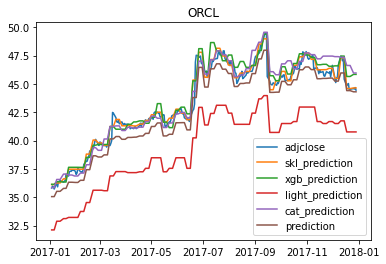

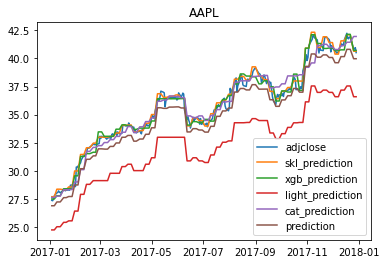

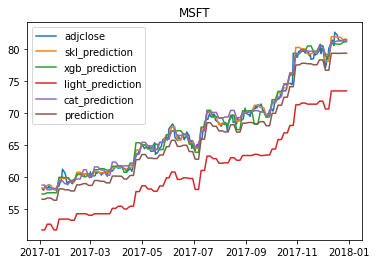

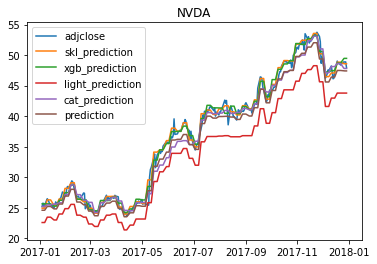

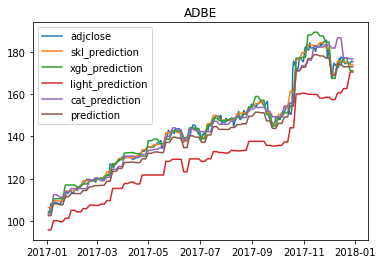

In [58]:
for ticker in ["ORCL","AAPL","MSFT","NVDA","ADBE"]:
    ticker_example = analysis[analysis["ticker"]==ticker].sort_values("date")
    plt.plot(ticker_example["date"],ticker_example["adjclose"])
    for col in [x for x in analysis.columns if "prediction" in x]:
        plt.plot(ticker_example["date"],ticker_example[col])
    legend = ["adjclose"]
    legend.extend([x for x in analysis.columns if "prediction" in x])
    plt.legend(legend)
    plt.title(ticker)
    plt.show()